In [9]:
#import libraries
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

from sklearn.metrics import classification_report 
from sklearn.model_selection import StratifiedKFold 

In [10]:
#use aggregate data for compressed size and pre-processed data
#load X_train_agg, y_train_agg and X_test_agg datasets
X_data = pd.read_pickle('/kaggle/input/amex-imputed-aggregate-data/X_train_agg.pkl', compression='gzip')
y_data = pd.read_pickle('/kaggle/input/amex-imputed-aggregate-data/y_train_agg.pkl', compression='gzip')
test_data = pd.read_pickle('/kaggle/input/amex-imputed-aggregate-data/X_test_agg.pkl', compression='gzip')

Function to calculate competition's evaluation metric: https://www.kaggle.com/code/inversion/amex-competition-metric-python

In [11]:
import pandas as pd

def amex_custom_metric(actual: pd.DataFrame, predicted: pd.DataFrame) -> float:
    def capture_top_four_percent(actual: pd.DataFrame, predicted: pd.DataFrame) -> float:
        combined_df = pd.concat([actual, predicted], axis=1).sort_values(by='prediction', ascending=False)
        combined_df['weight'] = combined_df['target'].map(lambda val: 20 if val == 0 else 1)
        
        cutoff_threshold = int(0.04 * combined_df['weight'].sum())
        combined_df['cumulative_weight'] = combined_df['weight'].cumsum()
        selected_df = combined_df[combined_df['cumulative_weight'] <= cutoff_threshold]
        
        return selected_df['target'].sum() / combined_df['target'].sum()

    def compute_weighted_gini(actual: pd.DataFrame, predicted: pd.DataFrame) -> float:
        merged_df = pd.concat([actual, predicted], axis=1).sort_values(by='prediction', ascending=False)
        merged_df['weight'] = merged_df['target'].map(lambda val: 20 if val == 0 else 1)

        merged_df['random_distribution'] = (merged_df['weight'] / merged_df['weight'].sum()).cumsum()
        total_positive = (merged_df['target'] * merged_df['weight']).sum()
        merged_df['cumulative_positive'] = (merged_df['target'] * merged_df['weight']).cumsum()
        merged_df['lorentz_curve'] = merged_df['cumulative_positive'] / total_positive
        merged_df['gini_coefficient'] = (merged_df['lorentz_curve'] - merged_df['random_distribution']) * merged_df['weight']

        return merged_df['gini_coefficient'].sum()

    def normalized_gini(actual: pd.DataFrame, predicted: pd.DataFrame) -> float:
        ideal_pred = actual.rename(columns={'target': 'prediction'})
        return compute_weighted_gini(actual, predicted) / compute_weighted_gini(actual, ideal_pred)

    gini_score = normalized_gini(actual, predicted)
    top_capture = capture_top_four_percent(actual, predicted)
    
    return 0.5 * (gini_score + top_capture)


## StratifiedKFold Training and Prediction

**StratifiedKFold()** is used to train and predict on the validation and test datasets. After testing different configurations, we found out that using **5 folds** provided the best results.

### **Key Hyperparameters**
- `n_estimators = 1000`
- `learning_rate = 0.03`
- `num_leaves = 50`
- `reg_alpha = 2`
- `min_child_samples = 2000`

Each fold includes plots of the **binary log loss**. Since **accuracy is not a supported metric** for `LGBMClassifier()`, it is replaced with **AUC (Area Under Curve)**.



Processing Fold 1...
[1]	training's auc: 0.929943	training's binary_logloss: 0.556339	validation's auc: 0.929723	validation's binary_logloss: 0.556375
[2]	training's auc: 0.939182	training's binary_logloss: 0.54256	validation's auc: 0.938889	validation's binary_logloss: 0.542581
[3]	training's auc: 0.941238	training's binary_logloss: 0.529806	validation's auc: 0.941097	validation's binary_logloss: 0.529879
[4]	training's auc: 0.94442	training's binary_logloss: 0.517316	validation's auc: 0.944239	validation's binary_logloss: 0.517443
[5]	training's auc: 0.945955	training's binary_logloss: 0.505905	validation's auc: 0.945727	validation's binary_logloss: 0.506069
[6]	training's auc: 0.946472	training's binary_logloss: 0.495364	validation's auc: 0.946149	validation's binary_logloss: 0.495575
[7]	training's auc: 0.947057	training's binary_logloss: 0.485073	validation's auc: 0.946576	validation's binary_logloss: 0.48535
[8]	training's auc: 0.94715	training's binary_logloss: 0.475639	validat

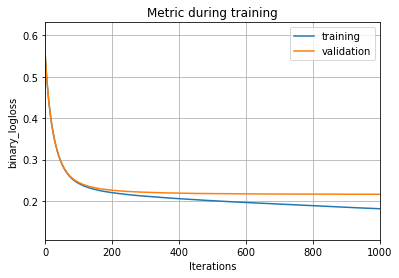


Processing Fold 2...
[1]	training's auc: 0.92981	training's binary_logloss: 0.556386	validation's auc: 0.928265	validation's binary_logloss: 0.556458
[2]	training's auc: 0.939427	training's binary_logloss: 0.54257	validation's auc: 0.937571	validation's binary_logloss: 0.542761
[3]	training's auc: 0.941616	training's binary_logloss: 0.529777	validation's auc: 0.93942	validation's binary_logloss: 0.530057
[4]	training's auc: 0.944837	training's binary_logloss: 0.517236	validation's auc: 0.942503	validation's binary_logloss: 0.517626
[5]	training's auc: 0.946288	training's binary_logloss: 0.505787	validation's auc: 0.944013	validation's binary_logloss: 0.50629
[6]	training's auc: 0.946716	training's binary_logloss: 0.495257	validation's auc: 0.944629	validation's binary_logloss: 0.495822
[7]	training's auc: 0.947343	training's binary_logloss: 0.484964	validation's auc: 0.945336	validation's binary_logloss: 0.485596
[8]	training's auc: 0.947269	training's binary_logloss: 0.47553	validati

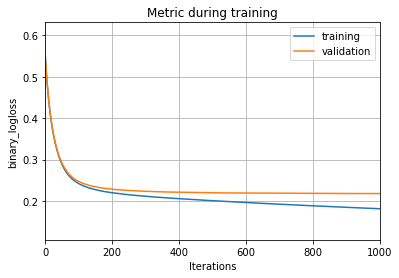


Processing Fold 3...
[1]	training's auc: 0.932434	training's binary_logloss: 0.556102	validation's auc: 0.931276	validation's binary_logloss: 0.556155
[2]	training's auc: 0.9402	training's binary_logloss: 0.542052	validation's auc: 0.939306	validation's binary_logloss: 0.542127
[3]	training's auc: 0.942007	training's binary_logloss: 0.528941	validation's auc: 0.941394	validation's binary_logloss: 0.529024
[4]	training's auc: 0.942941	training's binary_logloss: 0.516425	validation's auc: 0.942071	validation's binary_logloss: 0.516579
[5]	training's auc: 0.944608	training's binary_logloss: 0.504982	validation's auc: 0.943599	validation's binary_logloss: 0.505229
[6]	training's auc: 0.94524	training's binary_logloss: 0.494624	validation's auc: 0.944114	validation's binary_logloss: 0.49494
[7]	training's auc: 0.945186	training's binary_logloss: 0.484597	validation's auc: 0.944046	validation's binary_logloss: 0.484947
[8]	training's auc: 0.946254	training's binary_logloss: 0.474855	validat

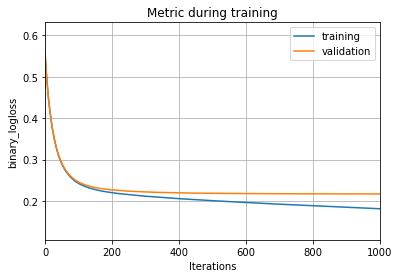


Processing Fold 4...
[1]	training's auc: 0.932482	training's binary_logloss: 0.556106	validation's auc: 0.930589	validation's binary_logloss: 0.556197
[2]	training's auc: 0.940245	training's binary_logloss: 0.542017	validation's auc: 0.938824	validation's binary_logloss: 0.542163
[3]	training's auc: 0.942036	training's binary_logloss: 0.528907	validation's auc: 0.940501	validation's binary_logloss: 0.529147
[4]	training's auc: 0.942893	training's binary_logloss: 0.516365	validation's auc: 0.941509	validation's binary_logloss: 0.516663
[5]	training's auc: 0.944532	training's binary_logloss: 0.504912	validation's auc: 0.943166	validation's binary_logloss: 0.505277
[6]	training's auc: 0.945043	training's binary_logloss: 0.494577	validation's auc: 0.943799	validation's binary_logloss: 0.494972
[7]	training's auc: 0.945096	training's binary_logloss: 0.484539	validation's auc: 0.943807	validation's binary_logloss: 0.484988
[8]	training's auc: 0.946156	training's binary_logloss: 0.474809	val

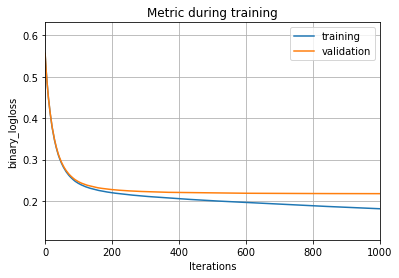


Processing Fold 5...
[1]	training's auc: 0.92235	training's binary_logloss: 0.556826	validation's auc: 0.921899	validation's binary_logloss: 0.556891
[2]	training's auc: 0.93753	training's binary_logloss: 0.542782	validation's auc: 0.937142	validation's binary_logloss: 0.542877
[3]	training's auc: 0.944477	training's binary_logloss: 0.528829	validation's auc: 0.943778	validation's binary_logloss: 0.528982
[4]	training's auc: 0.946335	training's binary_logloss: 0.516691	validation's auc: 0.945301	validation's binary_logloss: 0.516936
[5]	training's auc: 0.946296	training's binary_logloss: 0.50548	validation's auc: 0.945272	validation's binary_logloss: 0.505749
[6]	training's auc: 0.947147	training's binary_logloss: 0.494547	validation's auc: 0.946111	validation's binary_logloss: 0.494867
[7]	training's auc: 0.946969	training's binary_logloss: 0.484433	validation's auc: 0.945851	validation's binary_logloss: 0.484843
[8]	training's auc: 0.947982	training's binary_logloss: 0.473963	valida

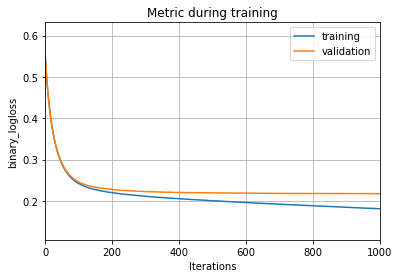

In [13]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

#define the optimal number of folds
k_folds = 5
kfold_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=25)

#initialize storage for predictions using numpy array
val_probabilities = np.zeros(X_data.shape[0])
val_predictions = np.zeros(X_data.shape[0])
test_predictions = np.zeros(test_data.shape[0])

#perform cross-validation between train and validation datasets
for fold_num, (train_idx, val_idx) in enumerate(kfold_splitter.split(X_data, y_data)):
    print(f'\nProcessing Fold {fold_num + 1}...')

    #split dataset into training and validation datasets
    X_train_set, X_val_set = X_data.iloc[train_idx].reset_index(drop=True), X_data.iloc[val_idx].reset_index(drop=True)
    y_train_set, y_val_set = y_data.iloc[train_idx].reset_index(drop=True), y_data.iloc[val_idx].reset_index(drop=True)

    #initialization and training the model
    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=1000,
        num_leaves=50,
        learning_rate=0.03,
        colsample_bytree=0.1,
        min_child_samples=2000,
        max_bins=500,
        reg_alpha=2,
        random_state=25
    )
    lgb_model.fit(
        X_train_set, y_train_set,
        eval_set=[(X_train_set, y_train_set), (X_val_set, y_val_set)],
        eval_names=['training', 'validation'],
        eval_metric=['auc']
    )

    #plot binary log loss for each fold
    metric_plot = lgb.plot_metric(lgb_model, metric='binary_logloss')
    plt.show()

    #nake predictions on validation dataset
    val_probabilities[val_idx] += lgb_model.predict_proba(X_val_set)[:, 1]
    val_predictions[val_idx] += lgb_model.predict(X_val_set)

    #predict testing dataset probabilities for current fold
    fold_test_probs = lgb_model.predict_proba(test_data)[:, 1]
    test_predictions += fold_test_probs / k_folds


In [21]:
# Prepare validation predictions for M score calculation
val_results = pd.DataFrame(y_data).copy(deep=True)
val_results = val_results.rename(columns={"target": "prediction"})
val_results["prediction"] = val_probabilities

# Compute and display the M score
m_score = amex_custom_metric(pd.DataFrame(y_data), val_results)
print(f"\nM Score: {m_score}")

# Display classification report
print(f"\n{classification_report(y_data, val_predictions)}")


M Score: 0.7920069386936385

              precision    recall  f1-score   support

           0       0.93      0.94      0.94    340085
           1       0.82      0.81      0.81    118828

    accuracy                           0.90    458913
   macro avg       0.88      0.87      0.87    458913
weighted avg       0.90      0.90      0.90    458913



In [ ]:
X_test = pd.read_pickle('X_test_agg.pkl', compression='gzip')

In [ ]:
submission = pd.DataFrame(lgb_model.predict_proba(X_test)[:,1], index=X_test.index, columns=['prediction'])

# index needs to be removed from submission csv
submission = submission.reset_index()
submission.to_csv('LGBM_submission.csv', index=False)